# Phân tích điểm thi THPT quốc gia 2017–2024
**Nội dung chính**  
1. Đọc và chuẩn hóa dữ liệu  
2. Làm sạch dữ liệu  
3. Gán cấp độ học lực theo môn  
4. Khai phá luật kết hợp (Association Rules)  
5. Trực quan phân bố cấp độ  
6. Kết luận & lưu kết quả  


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori

warnings.filterwarnings('ignore')

C:\Users\PC\AppData\Local\Temp\ipykernel_56956\1487105546.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Đọc và chuẩn hóa dữ liệu
- Đọc file CSV  
- Đổi tên cột  
- Chuyển các điểm thi về kiểu số  
- Tạo thêm cột tên tỉnh


In [2]:
# Đọc dữ liệu
df = pd.read_csv("datasets/du_lieu_diem_thi_2017_2024.csv")

# Đổi tên cột cho dễ làm việc
df.columns = ['nam', 'ma_tinh', 'sbd', 'toan', 'van', 'ly', 'hoa', 'sinh',
              'su', 'dia', 'gdcd', 'nn', 'ma_nn', 'tong_diem',
              'khoi_a', 'khoi_a1', 'khoi_b', 'khoi_c', 'khoi_d']

# Chuyển các cột điểm về kiểu số
cols_diem = ['toan', 'van', 'ly', 'hoa', 'sinh', 'su', 'dia', 'gdcd', 'nn',
             'tong_diem', 'khoi_a', 'khoi_a1', 'khoi_b', 'khoi_c', 'khoi_d']
df[cols_diem] = df[cols_diem].apply(pd.to_numeric, errors = 'coerce')

# Tạo cột tỉnh từ mã tỉnh
ma_tinh = {
    '01': 'Hà Nội', '02': 'TP. Hồ Chí Minh', '03': 'Hải Phòng', '04': 'Đà Nẵng',
    '05': 'Hà Giang', '06': 'Cao Bằng', '07': 'Lai Châu', '08': 'Lào Cai',
    '09': 'Tuyên Quang', '10': 'Lạng Sơn', '11': 'Bắc Kạn', '12': 'Thái Nguyên',
    '13': 'Yên Bái', '14': 'Sơn La', '15': 'Phú Thọ', '16': 'Vĩnh Phúc',
    '17': 'Quảng Ninh', '18': 'Bắc Giang', '19': 'Bắc Ninh', '21': 'Hải Dương',
    '22': 'Hưng Yên', '23': 'Hòa Bình', '24': 'Hà Nam', '25': 'Nam Định',
    '26': 'Thái Bình', '27': 'Ninh Bình', '28': 'Thanh Hóa', '29': 'Nghệ An',
    '30': 'Hà Tĩnh', '31': 'Quảng Bình', '32': 'Quảng Trị', '33': 'Thừa Thiên-Huế',
    '34': 'Quảng Nam', '35': 'Quảng Ngãi', '36': 'Kon Tum', '37': 'Bình Định',
    '38': 'Gia Lai', '39': 'Phú Yên', '40': 'Đắk Lắk', '41': 'Khánh Hòa',
    '42': 'Lâm Đồng', '43': 'Bình Phước', '44': 'Bình Dương', '45': 'Ninh Thuận',
    '46': 'Tây Ninh', '47': 'Bình Thuận', '48': 'Đồng Nai', '49': 'Long An',
    '50': 'Đồng Tháp', '51': 'An Giang', '52': 'Bà Rịa-Vũng Tàu', '53': 'Tiền Giang',
    '54': 'Kiên Giang', '55': 'Cần Thơ', '56': 'Bến Tre', '57': 'Vĩnh Long',
    '58': 'Trà Vinh', '59': 'Sóc Trăng', '60': 'Bạc Liêu', '61': 'Cà Mau',
    '62': 'Điện Biên', '63': 'Đắk Nông', '64': 'Hậu Giang'
}

df['ma_tinh_str'] = df['ma_tinh'].astype(str).str.zfill(2)
df['tinh'] = df['ma_tinh_str'].map(ma_tinh)

## 2. Làm sạch dữ liệu
- Loại bỏ dòng thiếu điểm Toán, Văn, Ngoại ngữ  
- Lọc học sinh không có tổng điểm  
- Loại bỏ bản ghi trùng lặp  
- Shuffle dữ liệu trước khi tiếp tục phân tích


In [3]:
print("Số dòng ban đầu:", len(df))

# Loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ (3 Môn thi bắt buộc nên nếu không có thì khả năng cao là không hợp lệ)
df = df[df[['toan', 'van', 'nn']].notna().all(axis = 1)]
print("Số dòng sau khi loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ:", len(df))

# Lọc học sinh không có tổng điểm
df = df[df['tong_diem'].notna()]
print(f"Số dòng sau khi lọc học sinh không có tổng điểm: {len(df)}")

# Kiểm tra và loại bỏ dòng trùng lặp
df = df.drop_duplicates()
print(f"Số dòng sau khi loại bỏ dòng trùng lặp: {len(df)}")
# Shuffle dữ liệu
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)
df.head(10)
print(df.head(10).to_markdown())

Số dòng ban đầu: 7609969
Số dòng sau khi loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ: 6629910
Số dòng sau khi lọc học sinh không có tổng điểm: 6579989
Số dòng sau khi loại bỏ dòng trùng lặp: 6569125
|    |   nam |   ma_tinh |   sbd |   toan |   van |     ly |    hoa |   sinh |     su |    dia |   gdcd |   nn | ma_nn   |   tong_diem |   khoi_a |   khoi_a1 |   khoi_b |   khoi_c |   khoi_d |   ma_tinh_str | tinh            |
|---:|------:|----------:|------:|-------:|------:|-------:|-------:|-------:|-------:|-------:|-------:|-----:|:--------|------------:|---------:|----------:|---------:|---------:|---------:|--------------:|:----------------|
|  0 |    17 |         2 |  2464 |    8.2 |  4.5  |   8    |   5.25 |    5   | nan    | nan    | nan    |  8.2 | nan     |       39.15 |    21.45 |     24.4  |    18.45 |   nan    |    20.9  |            02 | TP. Hồ Chí Minh |
|  1 |    23 |        48 |  9389 |    8.4 |  5    |   7.5  |   8    |    4.5 | nan    | nan    | nan    |  5.2 | N1 

- Chia tách thành hai tập con: KHTN & KHXH

In [ ]:
df_khtn = df.loc[df[['su','dia','gdcd']].isna().all(axis=1)]
df_khxh = df.loc[df[['ly','hoa','sinh']].isna().all(axis=1)]
print(f"KHTN rows: {len(df_khtn)}, KHXH rows: {len(df_khxh)}, total: {len(df)}")


KHTN rows: 2486137, KHXH rows: 3959142, total: 6569125


## 3. Gán cấp độ học lực theo môn <a id="section-level"></a>

- Sử dụng `pd.cut` (vectorized) để phân nhóm:
  - `XuatSac` (≥ 9)
  - `Gioi` (≥ 8 & < 9)
  - `Kha` (≥ 7 & < 8)
  - `TrungBinh` (≥ 6.5 & < 7)
  - `Kem` (< 5)
- Kết quả lưu vào DataFrame `df_levels`

In [ ]:

# 2) Vectorized level mapping for all subjects
subjects = ['toan','ly','hoa','van','su','dia','sinh','gdcd','nn']
bins = [-np.inf, 5, 6.5, 7, 9, np.inf]
labels = ['Kem','TrungBinh','Kha','Gioi','XuatSac']
df_levels = pd.DataFrame({
    f'{mon}_level': pd.cut(df[mon], bins=bins, labels=labels, right=False)
    for mon in subjects
}, index=df.index)

## 4. Khai phá luật kết hợp (Association Rules) <a id="section-rules"></a>

1. One-hot encode các cột mức độ (`level`)  
2. Áp dụng `apriori` để tìm mục frequent itemsets  
3. Sinh luật với `association_rules`  
4. Lọc theo `min_support` & `min_confidence`

In [ ]:
def process_subset(df_subset, plot_subjs, min_supp, title):
    # a) Join subset với các cột level
    df2 = pd.concat([df_subset, df_levels.loc[df_subset.index]], axis=1)

    # b) One-hot encode tất cả các cột mức độ
    cats_all = [f'{mon}_level' for mon in subjects]
    df_bool  = pd.get_dummies(df2[cats_all], prefix_sep='=')

    # c) Apriori/FP-Growth và sinh luật
    freq  = apriori(df_bool, min_support=min_supp, use_colnames=True)

    # d) Tính % cho stacked-bar (vectorized)
    lvl_cols = [f'{subj}_level' for subj in plot_subjs]
    pct = df2[lvl_cols].apply(
        lambda col: col.value_counts(normalize=True)
                       .reindex(labels, fill_value=0) * 100
    )

    # e) Vẽ stacked-bar
    ind    = np.arange(len(plot_subjs))
    bottom = np.zeros(len(plot_subjs))
    plt.figure(figsize=(8,5))
    for lvl in labels:
        vals = pct.loc[lvl].values
        plt.bar(ind, vals, bottom=bottom, label=lvl)
        bottom += vals
    plt.xticks(ind, plot_subjs, rotation=45)
    plt.ylabel('Tỷ lệ (%)')
    plt.title(title)
    plt.legend(title='Cấp độ', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return freq

## 5. Trực quan phân bố cấp độ <a id="section-visual"></a>

- Vẽ biểu đồ stacked-bar so sánh tỷ lệ từng cấp độ theo môn  
- Chạy riêng cho KHTN và KHXH để dễ so sánh  
- Màu sắc & chú thích rõ ràng, trực quan

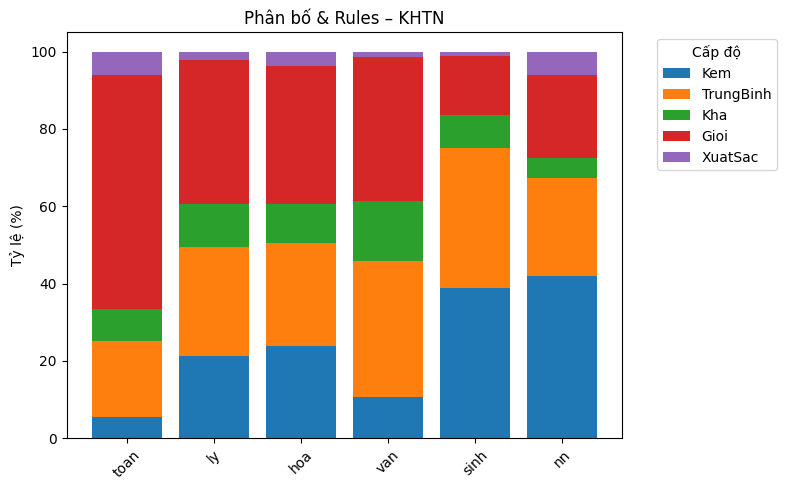

In [ ]:
# 4) Run for KHTN and KHXH
freq_khtn = process_subset(
    df_khtn,
    plot_subjs=['toan','ly','hoa','van','sinh','nn'],
    min_supp=0.1,
    title='Phân bố & Rules – KHTN'
)

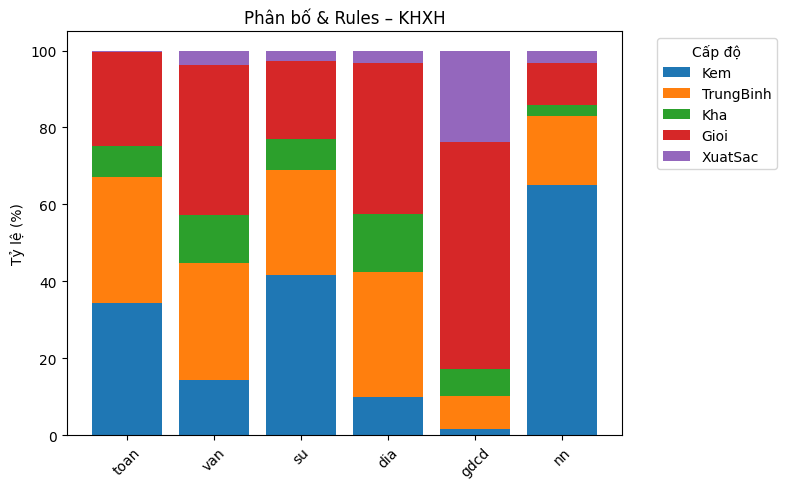

In [ ]:
freq_khxh = process_subset(
    df_khxh,
    plot_subjs=['toan','van','su','dia','gdcd','nn'],
    min_supp=0.1,
    title='Phân bố & Rules – KHXH'
)

In [ ]:
rules_khtn = association_rules(freq_khtn, metric="confidence", min_threshold=0.8)
rules_khxh = association_rules(freq_khxh, metric="confidence", min_threshold=0.8)

## 6. Kết quả <a id="section-conclude"></a>

- Top rules quan trọng nhất cho KHTN & KHXH  

In [ ]:
# 5) Display top 10 rules each
print("=== Top 10 KHTN Rules ===")
print(rules_khtn.sort_values('lift', ascending=False)
      [['antecedents','consequents','support','confidence','lift']]
      .head(10).to_markdown())

print("\n=== Top 10 KHXH Rules ===")
print(rules_khxh.sort_values('lift', ascending=False)
      [['antecedents','consequents','support','confidence','lift']]
      .head(10).to_markdown())


=== Top 10 KHTN Rules ===
|    | antecedents                                           | consequents                    |   support |   confidence |    lift |
|---:|:------------------------------------------------------|:-------------------------------|----------:|-------------:|--------:|
|  3 | frozenset({'ly_level=Gioi', 'hoa_level=Gioi'})        | frozenset({'toan_level=Gioi'}) |  0.174235 |     0.847274 | 1.39663 |
|  6 | frozenset({'hoa_level=Gioi', 'van_level=Gioi'})       | frozenset({'toan_level=Gioi'}) |  0.144972 |     0.840808 | 1.38597 |
|  4 | frozenset({'ly_level=Gioi', 'van_level=Gioi'})        | frozenset({'toan_level=Gioi'}) |  0.147123 |     0.838637 | 1.38239 |
|  1 | frozenset({'hoa_level=Gioi'})                         | frozenset({'toan_level=Gioi'}) |  0.294119 |     0.820209 | 1.35202 |
|  5 | frozenset({'ly_level=Gioi', 'sinh_level=TrungBinh'})  | frozenset({'toan_level=Gioi'}) |  0.120963 |     0.819765 | 1.35129 |
|  0 | frozenset({'ly_level=Gioi'})        


**Nhận xét KHTN**  
- Học sinh giỏi **Lý + Hóa** có đến ~84.7 % khả năng giỏi Toán (lift ~1.40 so với ngẫu nhiên).  
- Chỉ cần giỏi **Hóa** hoặc **Lý** hoặc **Văn** riêng lẻ đã cho confidence ~82 %.  
- Sinh học ở mức **Kha**/“TrungBình” kết hợp nhẹ với Toán giỏi (lift ~1.32–1.35).

> **Kết luận**: Để cải thiện Toán, nên tập trung song hành với Lý–Hóa.

**Nhận xét KHXH**  
- Điểm **kém** Toán + Văn ⇒ kém Ngoại ngữ cực mạnh (confidence ~96 %).  
- Chỉ kém Toán vẫn cho ~91 % khả năng kém Ngoại ngữ (lift ~1.40).  
- Thêm “kém Sử/Địa” đẩy confidence lên ~94–96 %.

> **Kết luận**: Khối XH nên ưu tiên củng cố Toán + Văn để tránh kéo điểm Ngoại ngữ xuống.

---

## Tổng kết

1. **Khối tự nhiên**: Toán/Lý/Hóa gắn chặt, giỏi môn nọ thường kèm giỏi môn kia.  
2. **Khối xã hội**: Kém môn cốt lõi (Toán, Văn, Sử, Địa) là dấu hiệu rất mạnh cho việc kém Ngoại ngữ.